# Kolokvij 2: priprema

In [1]:
import nltk
from nltk2tikz import show_parse
import random

## Zadatak 1

Napišite gramatiku obogaćenu značajkama koja opisuje sljedeće rečenice:
```
Hrabar čovjek je odlučio.

```

In [5]:
%%writefile grammar.fcfg
# grammar productions
% start S
S -> NP[NUM=?n] VP[NUM=?n]
## NP productions
NP[NUM=?n, GEN=?g] -> Adj[NUM=?n, GEN=?g] N[NUM=?n, GEN=?g]
NP[NUM=?n, GEN=?g] -> N[NUM=?n, GEN=?g]
## VP productions
VP[TENSE=?t, -AUX] -> V[TENSE=?t, -AUX]
VP[TENSE=?t, NUM=?n] -> V[TENSE=?t,+AUX] VP[TENSE=?t,-AUX]
## lexical productions
N[NUM=sg, GEN=m] -> 'čovjek'
Adj[NUM=sg,GEN=m] -> 'hrabar'
V[TENSE=past,+AUX] -> 'je'
V[TENSE=past,-AUX] -> 'odlučio'

Overwriting grammar.fcfg


In [6]:
# CFG obogaćena s dodatnim značajkama
nltk.data.show_cfg('grammar.fcfg')

# grammar productions
% start S
S -> NP[NUM=?n] VP[NUM=?n]
NP[NUM=?n, GEN=?g] -> Adj[NUM=?n, GEN=?g] N[NUM=?n, GEN=?g]
NP[NUM=?n, GEN=?g] -> N[NUM=?n, GEN=?g]
VP[TENSE=?t, -AUX] -> V[TENSE=?t, -AUX]
VP[TENSE=?t, NUM=?n] -> V[TENSE=?t,+AUX] VP[TENSE=?t,-AUX]
N[NUM=sg, GEN=m] -> 'čovjek'
Adj[NUM=sg,GEN=m] -> 'hrabar'
V[TENSE=past,+AUX] -> 'je'
V[TENSE=past,-AUX] -> 'odlučio'


In [7]:
cp = nltk.load_parser('grammar.fcfg')
print(cp.grammar())

Grammar with 9 productions (start state = S[])
    S[] -> NP[NUM=?n] VP[NUM=?n]
    NP[GEN=?g, NUM=?n] -> Adj[GEN=?g, NUM=?n] N[GEN=?g, NUM=?n]
    NP[GEN=?g, NUM=?n] -> N[GEN=?g, NUM=?n]
    VP[-AUX, TENSE=?t] -> V[-AUX, TENSE=?t]
    VP[NUM=?n, TENSE=?t] -> V[+AUX, TENSE=?t] VP[-AUX, TENSE=?t]
    N[GEN='m', NUM='sg'] -> 'čovjek'
    Adj[GEN='m', NUM='sg'] -> 'hrabar'
    V[+AUX, TENSE='past'] -> 'je'
    V[-AUX, TENSE='past'] -> 'odlučio'


In [14]:
sentence = 'hrabar čovjek je odlučio'


In [15]:
# parsiranje
from nltk.tokenize import word_tokenize
tokens = word_tokenize(sentence.lower())

No X server, using TikZ engine ...


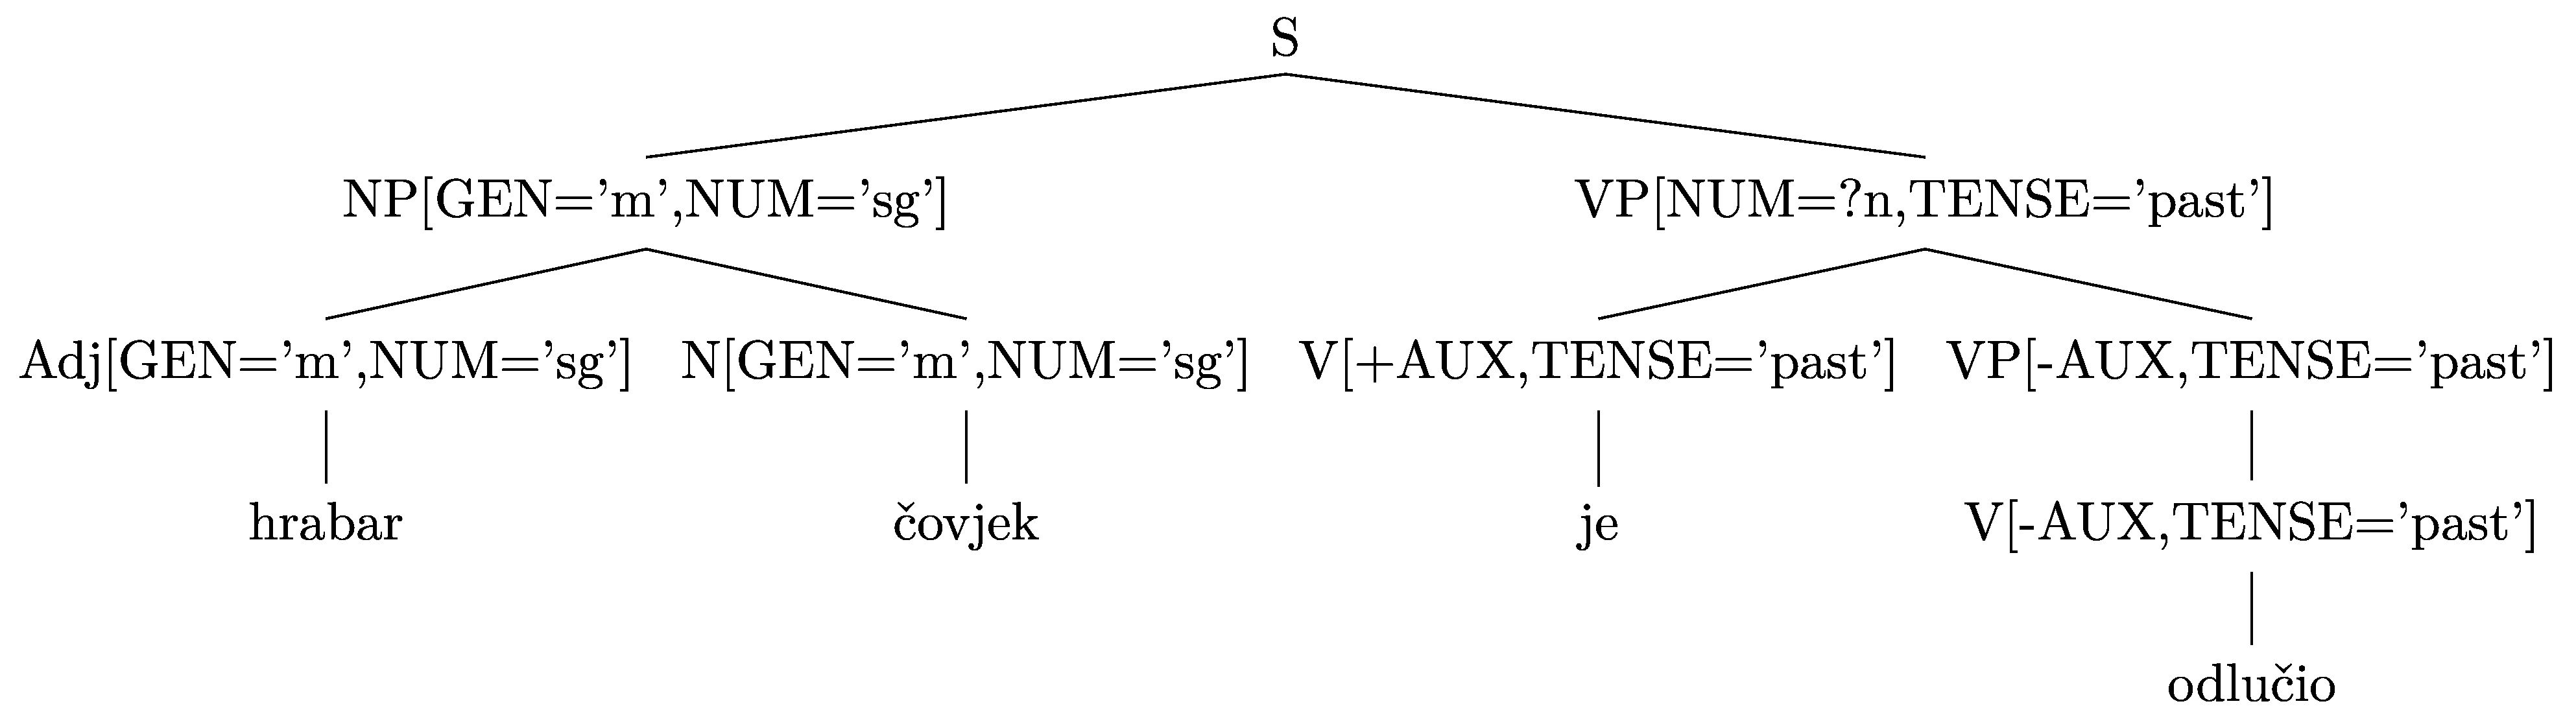

In [18]:
# ucitaj parser i parsiraj recenicu

trees = list(cp.parse(tokens))

tree = trees[0]
show_parse(tree,width=800)

## Zadatak 2

Napišite program za semantičko parsiranje sljedećih rečenica:
 ```
 Snoopy runs.
 Woodstock flies. 
 ```
 * Napišite gramatiku obogaćenu značajkama koja pretvora tekst u odgovarajući $\lambda$ izraz.
 * dajte model s evaluacijom koji će provjeriti istinistost sljedećih rečenica: `Snoopy runs, Woodstock flies,Woodstock runs`

In [19]:
%%writefile sem.fcfg
% start S
# Grammar Rules
S[SEM=<?vp(?np)>] -> NP[SEM=?np] VP[SEM=?vp]
VP[SEM=?v] -> IV[SEM=?v]
# Lexical Rules
NP[SEM=<snoopy>] -> 'Snoopy'
NP[SEM=<woodstock>] -> 'Woodstock'
IV[SEM=<\x.run(x)>] -> 'runs'
IV[SEM=<\x.fly(x)>] -> 'flies'

Overwriting sem.fcfg


In [20]:
#sentence = 'Snoopy runs'
sentence = 'Woodstock flies'

In [21]:
# parsiranje
from nltk.tokenize import word_tokenize
tokens = word_tokenize(sentence)

cp = nltk.load_parser('sem.fcfg')
trees = cp.parse_all(tokens)

tree = list(trees)


for tree in trees:
    print(tree.label()['SEM'])

fly(woodstock)


In [22]:
# valuacija modela 
# postavljamo model
v = """
    snoopy => s
    woodstock => w
    run => {s}
    fly => {w}    
    
"""
val = nltk.Valuation.fromstring(v)

g = nltk.Assignment(val.domain)
m = nltk.Model(val.domain, val)
sents = ['Snoopy runs','Woodstock flies','Woodstock runs']

# nasa gramatika
grammar_file = 'sem.fcfg'

results = nltk.evaluate_sents(sents, grammar_file, m, g)
# ispis semantičke reprezentacije i valuacije iste
for result in results:
    for (synrep, semrep, value) in result:
        print(synrep)
        print(semrep)
        print(value)

(S[SEM=<run(snoopy)>]
  (NP[SEM=<snoopy>] Snoopy)
  (VP[SEM=<\x.run(x)>] (IV[SEM=<\x.run(x)>] runs)))
run(snoopy)
True
(S[SEM=<fly(woodstock)>]
  (NP[SEM=<woodstock>] Woodstock)
  (VP[SEM=<\x.fly(x)>] (IV[SEM=<\x.fly(x)>] flies)))
fly(woodstock)
True
(S[SEM=<run(woodstock)>]
  (NP[SEM=<woodstock>] Woodstock)
  (VP[SEM=<\x.run(x)>] (IV[SEM=<\x.run(x)>] runs)))
run(woodstock)
False


## Zadatak 3 

Implementirajte POS označavatelj koristeći naivni Bayes klasifikator koji će na temelju dane engleske riječi odrediti uPOS oznaku. Za značajke riječi odaberite prvih 100 najčešćih sufiksa duljine 1,2,3.  Možete iskoristiti Brownov korpus s u POS oznakama te treniranje i testiranje. Preciznost modela mora biti barem 70%. Utvrdite koja oznaka ima najveću $F_1$ ocjenu.

In [23]:
# korpus s POS oznakama
from nltk.corpus import brown
# POS odredjen sufiskom riječi?
suffix_fdist = nltk.FreqDist()

# izracunaj frekvenciju sufiksa duljine 1,2,3
words = [w.lower() for w in brown.words() if w.isalnum()]
for word in words:
    suffix_fdist[word[-1:]] += 1 # jednočlani sufiks
    suffix_fdist[word[-2:]] += 1 # dvočlani sufiks
    suffix_fdist[word[-3:]] += 1 # tročlani sufiks
    
# najcesci sufiks
common_suffixes = [suffix for (suffix, count) in suffix_fdist.most_common(100)]

print(common_suffixes)

def pos_features(word):
    features = {}
    for suffix in common_suffixes:
        features['endswith({})'.format(suffix)] = word.lower().endswith(suffix)
    return features



['e', 's', 'd', 'he', 't', 'n', 'a', 'of', 'the', 'y', 'r', 'to', 'in', 'f', 'o', 'ed', 'nd', 'is', 'on', 'l', 'and', 'g', 'ng', 'er', 'as', 'ing', 'h', 'at', 'es', 'or', 're', 'it', 'an', 'm', 'i', 'ly', 'ion', 'en', 'al', 'be', 'nt', 'hat', 'st', 'his', 'th', 'le', 'll', 'by', 'ce', 'ts', 'me', 'se', 've', 'ut', 'was', 'for', 'ent', 'ch', 'w', 'k', 'ld', 'rs', 'ted', 'ere', 'her', 'ne', 'ns', 'ith', 'ad', 'ry', 'te', 'ty', 'ay', 'ot', 'p', 'nce', 'om', 'ter', 'ss', 'we', 'are', 'c', 'uld', 'ers', 'had', 'so', 'ey', 'one', 'all', 'not', 'ow', 'us', 'ons', 'ave', 'out', 'et', 'ar', 'ic', 'ge', 'de']


In [24]:
print(pos_features('ale'))

{'endswith(e)': True, 'endswith(s)': False, 'endswith(d)': False, 'endswith(he)': False, 'endswith(t)': False, 'endswith(n)': False, 'endswith(a)': False, 'endswith(of)': False, 'endswith(the)': False, 'endswith(y)': False, 'endswith(r)': False, 'endswith(to)': False, 'endswith(in)': False, 'endswith(f)': False, 'endswith(o)': False, 'endswith(ed)': False, 'endswith(nd)': False, 'endswith(is)': False, 'endswith(on)': False, 'endswith(l)': False, 'endswith(and)': False, 'endswith(g)': False, 'endswith(ng)': False, 'endswith(er)': False, 'endswith(as)': False, 'endswith(ing)': False, 'endswith(h)': False, 'endswith(at)': False, 'endswith(es)': False, 'endswith(or)': False, 'endswith(re)': False, 'endswith(it)': False, 'endswith(an)': False, 'endswith(m)': False, 'endswith(i)': False, 'endswith(ly)': False, 'endswith(ion)': False, 'endswith(en)': False, 'endswith(al)': False, 'endswith(be)': False, 'endswith(nt)': False, 'endswith(hat)': False, 'endswith(st)': False, 'endswith(his)': Fals

In [28]:
# skup podatka
tagged_words = list(brown.tagged_words(categories='news',tagset='universal'))[:1000]
random.shuffle(tagged_words)
tagged_words[:5]

[('previous', 'ADJ'),
 (',', '.'),
 ('``', '.'),
 ('that', 'ADP'),
 ('1937', 'NUM')]

In [29]:
size = int(len(tagged_words) * 0.2)

# popis rijeci za treniranje i testiranje
train_tagged_words, test_tagged_words = tagged_words[size:], tagged_words[:size]

# particioniraj na train i test
train_set = [(pos_features(w), t) for (w,t) in train_tagged_words]
test_set = [(pos_features(w), t) for (w,t) in test_tagged_words]



# klasifikator
classifier = nltk.NaiveBayesClassifier.train(train_set)
# mjera preciznosti
nltk.classify.accuracy(classifier, test_set)


0.71

In [30]:
classifier.classify(pos_features('cats'))

'NOUN'

In [31]:
classifier.show_most_informative_features(5)

Most Informative Features
            endswith(nd) = True             CONJ : NOUN   =     92.6 : 1.0
            endswith(it) = True             PRON : NOUN   =     85.0 : 1.0
             endswith(o) = True              PRT : VERB   =     64.9 : 1.0
             endswith(e) = True              DET : ADP    =     44.1 : 1.0
            endswith(al) = True              ADJ : NOUN   =     31.4 : 1.0


In [32]:
reference = [t for (w,t) in test_tagged_words]
test = [classifier.classify(pos_features(w)) for (w,t) in test_tagged_words]

In [33]:
from nltk.metrics import ConfusionMatrix
cm = ConfusionMatrix(reference, test)
print(cm.evaluate())

 Tag | Prec.  | Recall | F-measure
-----+--------+--------+-----------
   . | 0.7907 | 1.0000 | 0.8831
 ADJ | 0.0000 | 0.0000 | 0.0000
 ADP | 0.8235 | 0.7778 | 0.8000
 ADV | 0.0000 | 0.0000 | 0.0000
CONJ | 0.7500 | 0.6000 | 0.6667
 DET | 0.9565 | 0.7857 | 0.8627
NOUN | 0.6410 | 0.7692 | 0.6993
 NUM | 1.0000 | 0.2500 | 0.4000
PRON | 1.0000 | 0.3333 | 0.5000
 PRT | 1.0000 | 1.0000 | 1.0000
VERB | 0.6818 | 0.5556 | 0.6122

